In [23]:
using Plots
using LaTeXStrings
using Printf

In [24]:
# Parameters (normalized)
r_s = 1.0       # Rational surface location
B_θ0 = 1.0       # Poloidal field amplitude
B_z = 1.0        # Toroidal field (constant)
R = 1.0          # Major radius
m, n = 2, 1     # Mode numbers (q = m/n = 2 at r_s)
L_s_values = [0.2, 0.5, 1.0];  # Different shear lengths to compare

In [25]:
# Calculate C to ensure q(r_s) = m/n
C = (r_s * B_z * n) / (R * m)   # Now B_θ0 is absorbed into scaling

# Define B_θ(r) such that B_θ(r) ~ r for large r (to make q(r) flatten or increase)
B_θ(r, L_s) = (r / r_s) * (tanh((r - r_s)/L_s) + C) / (1 + C)  # Normalized to B_θ(r_s) = (r_s B_z n)/(R m)

# Safety factor
q(r, L_s) = (r * B_z) / (R * B_θ(r, L_s))

# Range for r (avoid division by zero)
r_min, r_max = 0.1, 2.0
r = range(r_min, r_max, length=300);

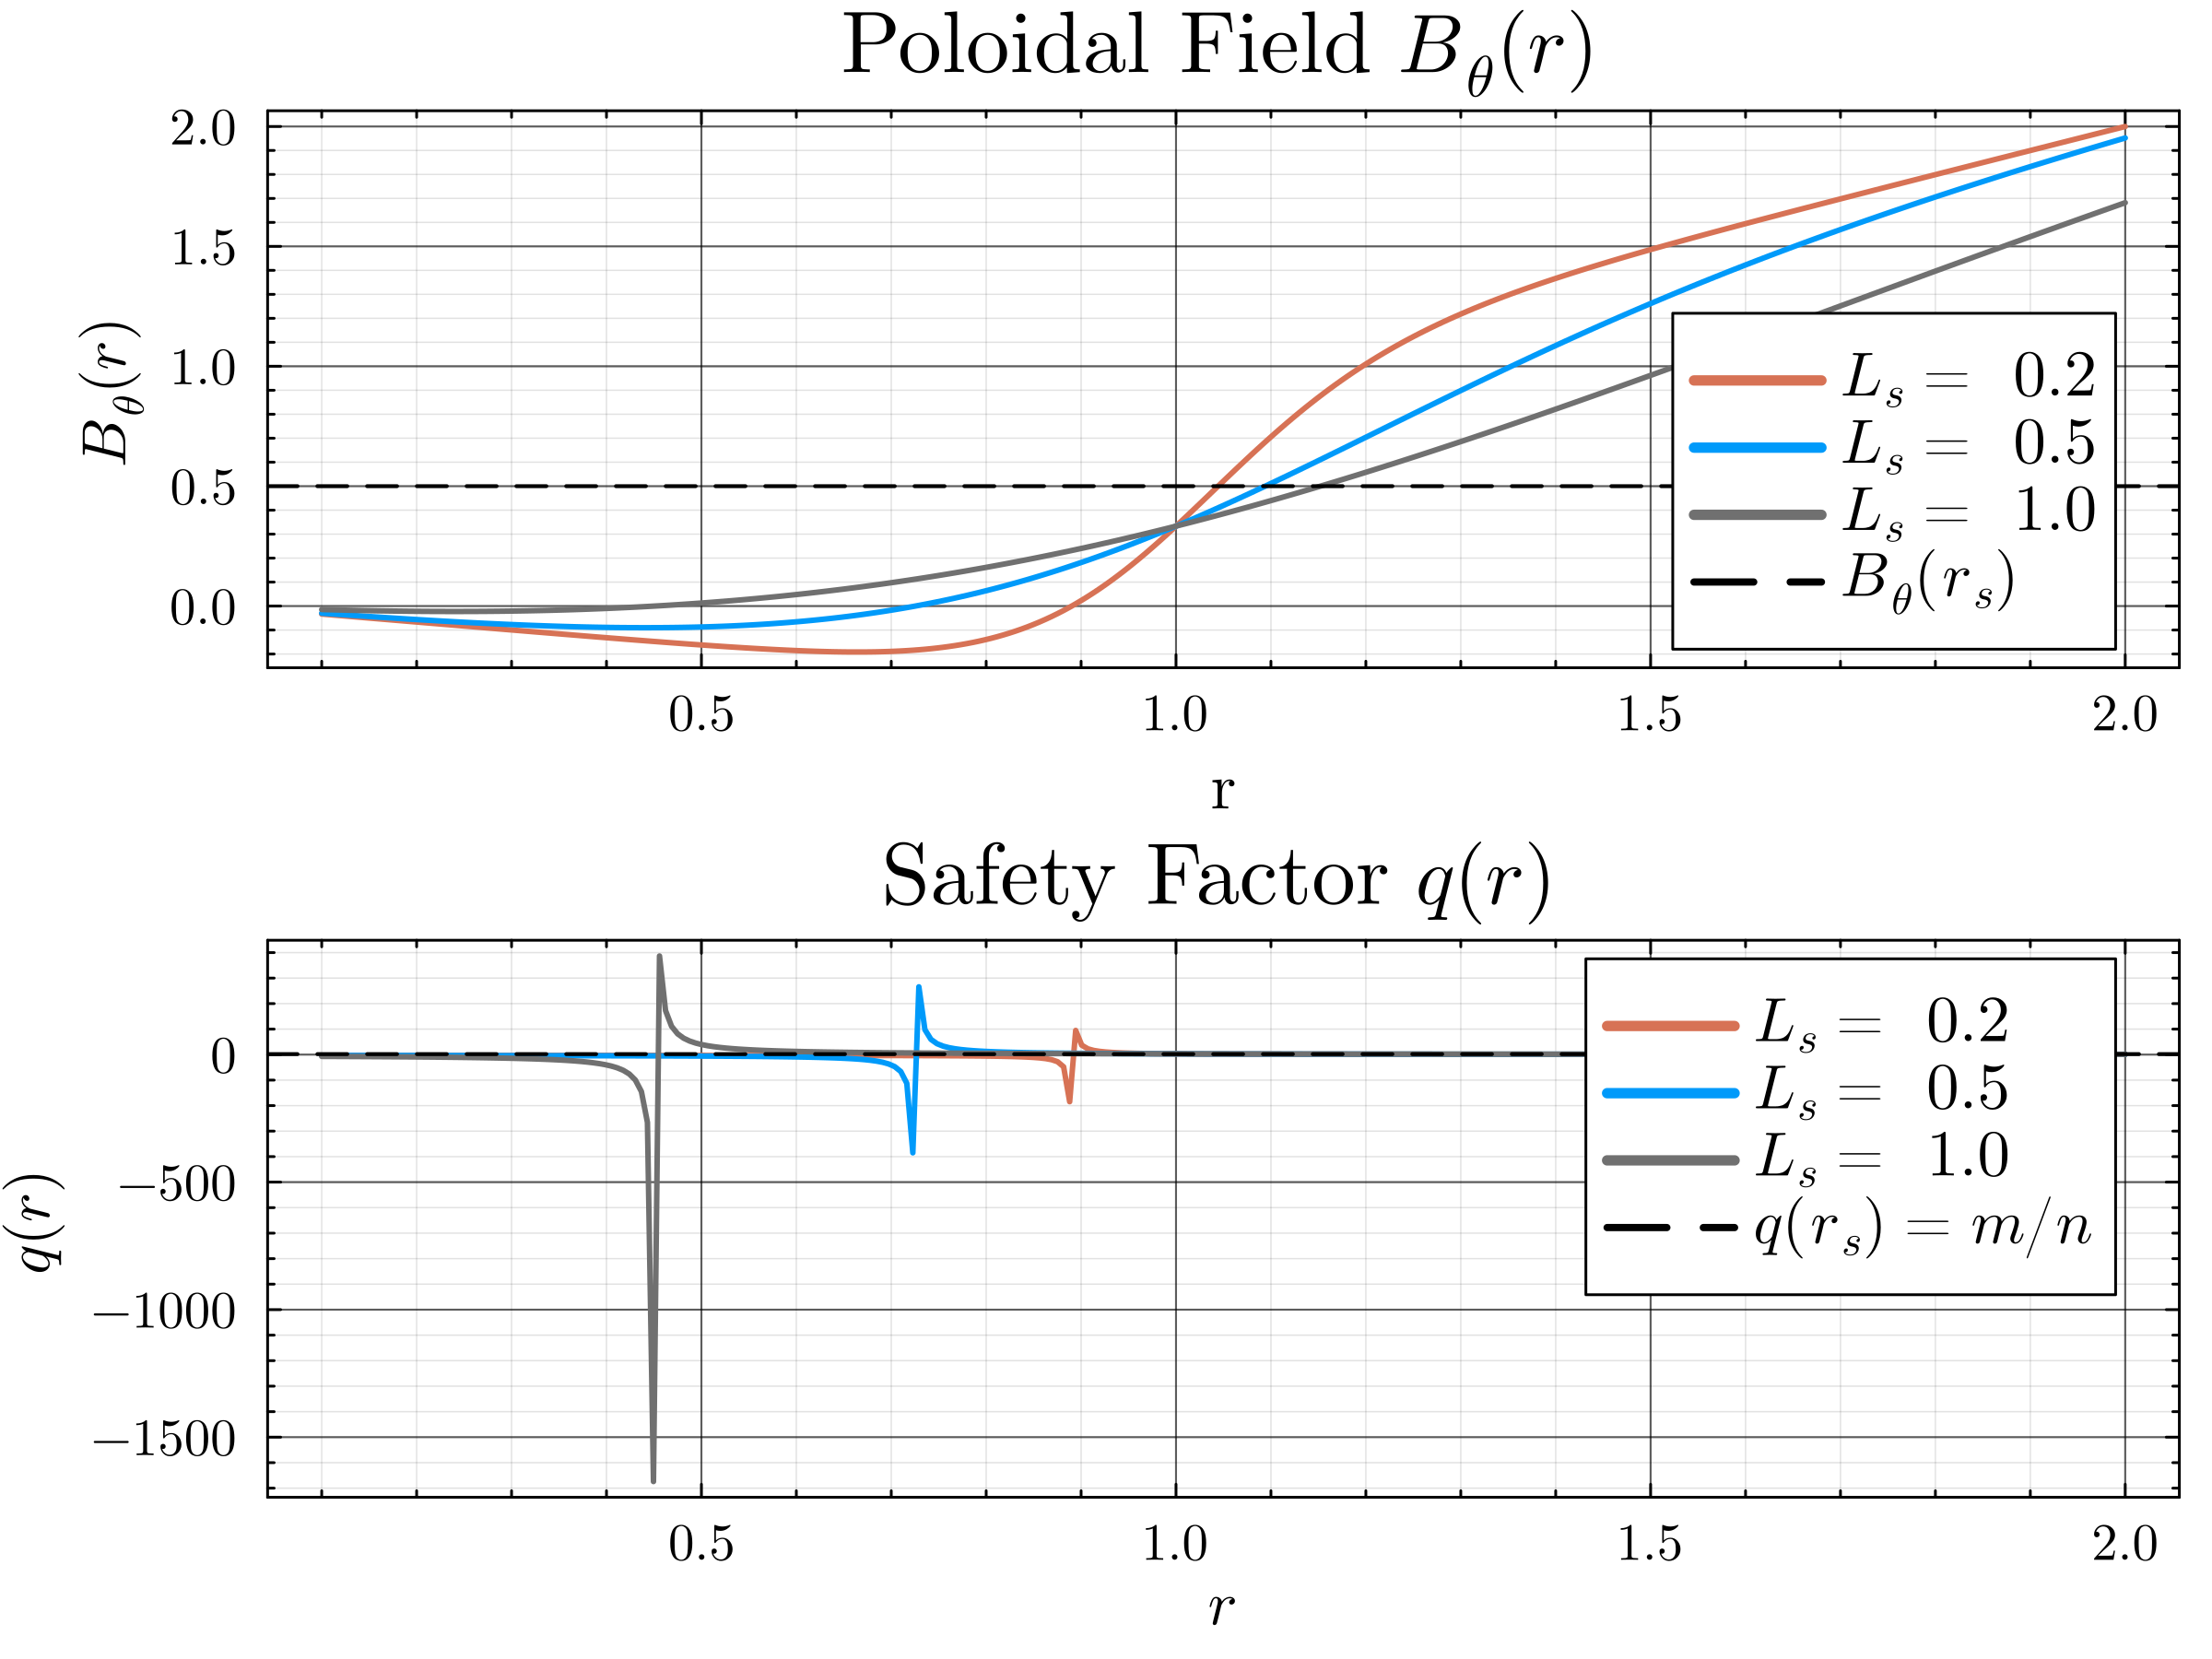

In [26]:
# Plot B_θ(r) for different L_s
theme(:dao)

plt_B = plot(title=L"Poloidal Field $B_{\theta}(r)$", xlabel="r", ylabel=L"$B_{\theta}(r)$", legend=:bottomright)
for L_s in L_s_values
    plot!(r, B_θ.(r, L_s), label=L"$L_s=$ %$L_s", lw=2)
end
hline!([B_θ0 * C], linestyle=:dash, color=:black, label=L"$B_{\theta}(r_s)$")

# Plot q(r) for different L_s
plt_q = plot(title=L"Safety Factor $q(r)$", xlabel=L"$r$", ylabel=L"$q(r)$", legend=:topright)
for L_s in L_s_values
    plot!(r, q.(r, L_s), label=L"$L_s =$ %$L_s", lw=2)
end
hline!([m/n], linestyle=:dash, color=:black, label=L"$q(r_s) = m/n$")

# Combine plots
plot(plt_B, plt_q, layout=(2,1), size=(800,600), 
    titlefontsize=20,
    tickfontsize=12,
    legendfontsize=15,
    yguidefontsize=15,
    xguidefontsize=15,
    dpi = 300
    )

In [27]:
using Optim

# Parameters (fixed)
a = 1.0          # Plasma edge
r_s = 0.5a       # Rational surface
m_n = 2.0        # q(r_s) = m/n
L_s = 0.2a       # Shear length
C = 0.5          # Slab model parameter

# Target shear at r_s
target_shear = (m_n / L_s) * (1 - C^2)  # = 7.5/a

# Power-law profile function
function q_profile(r, params)
    q₀, μ, γ, r₀ = params
    return q₀ * (1 + (r/r₀)^μ)^γ
end

# Derivative of q at r_s
function dq_dr(r_s, params)
    q₀, μ, γ, r₀ = params
    term = 1 + (r_s/r₀)^μ
    return (q₀ * μ * γ * (r_s/r₀)^(μ-1) * term^(γ-1)) / r₀
end

# Objective function (sum of squared errors)
function objective(params)
    q₀, μ, γ, r₀ = params
    
    # Constraint 1: q(r_s) = m/n
    q_r_s = q_profile(r_s, params)
    error_q = (q_r_s - m_n)^2
    
    # Constraint 2: dq/dr matches target shear
    computed_shear = dq_dr(r_s, params)
    error_shear = (computed_shear - target_shear)^2
    
    # Penalize non-monotonicity (test 100 points)
    r_test = range(0.01a, a, length=100)
    dqdr_test = [dq_dr(r, params) for r in r_test]
    monotonicity_penalty = sum(max.(0, -dqdr_test)) * 1e6
    
    return error_q + error_shear + monotonicity_penalty
end

# Initial guess and bounds
initial_params = [0.8, 2.0, 1.0, 0.5a]
lower_bounds = [0.1, 1.0, 0.1, 0.1a]
upper_bounds = [2.0, 5.0, 3.0, 1.0a]

# Run optimization (using Fminbox with LBFGS)
result = optimize(objective, lower_bounds, upper_bounds, initial_params, Fminbox(LBFGS()))

# Extract results
q₀_opt, μ_opt, γ_opt, r₀_opt = result.minimizer
println("Optimized parameters: q₀ = ", q₀_opt, ", μ = ", μ_opt, ", γ = ", γ_opt, ", r₀ = ", r₀_opt)

Optimized parameters: q₀ = 0.9386177771726912, μ = 3.1244730363030775, γ = 1.5676658891795887, r₀ = 0.5825952881167751


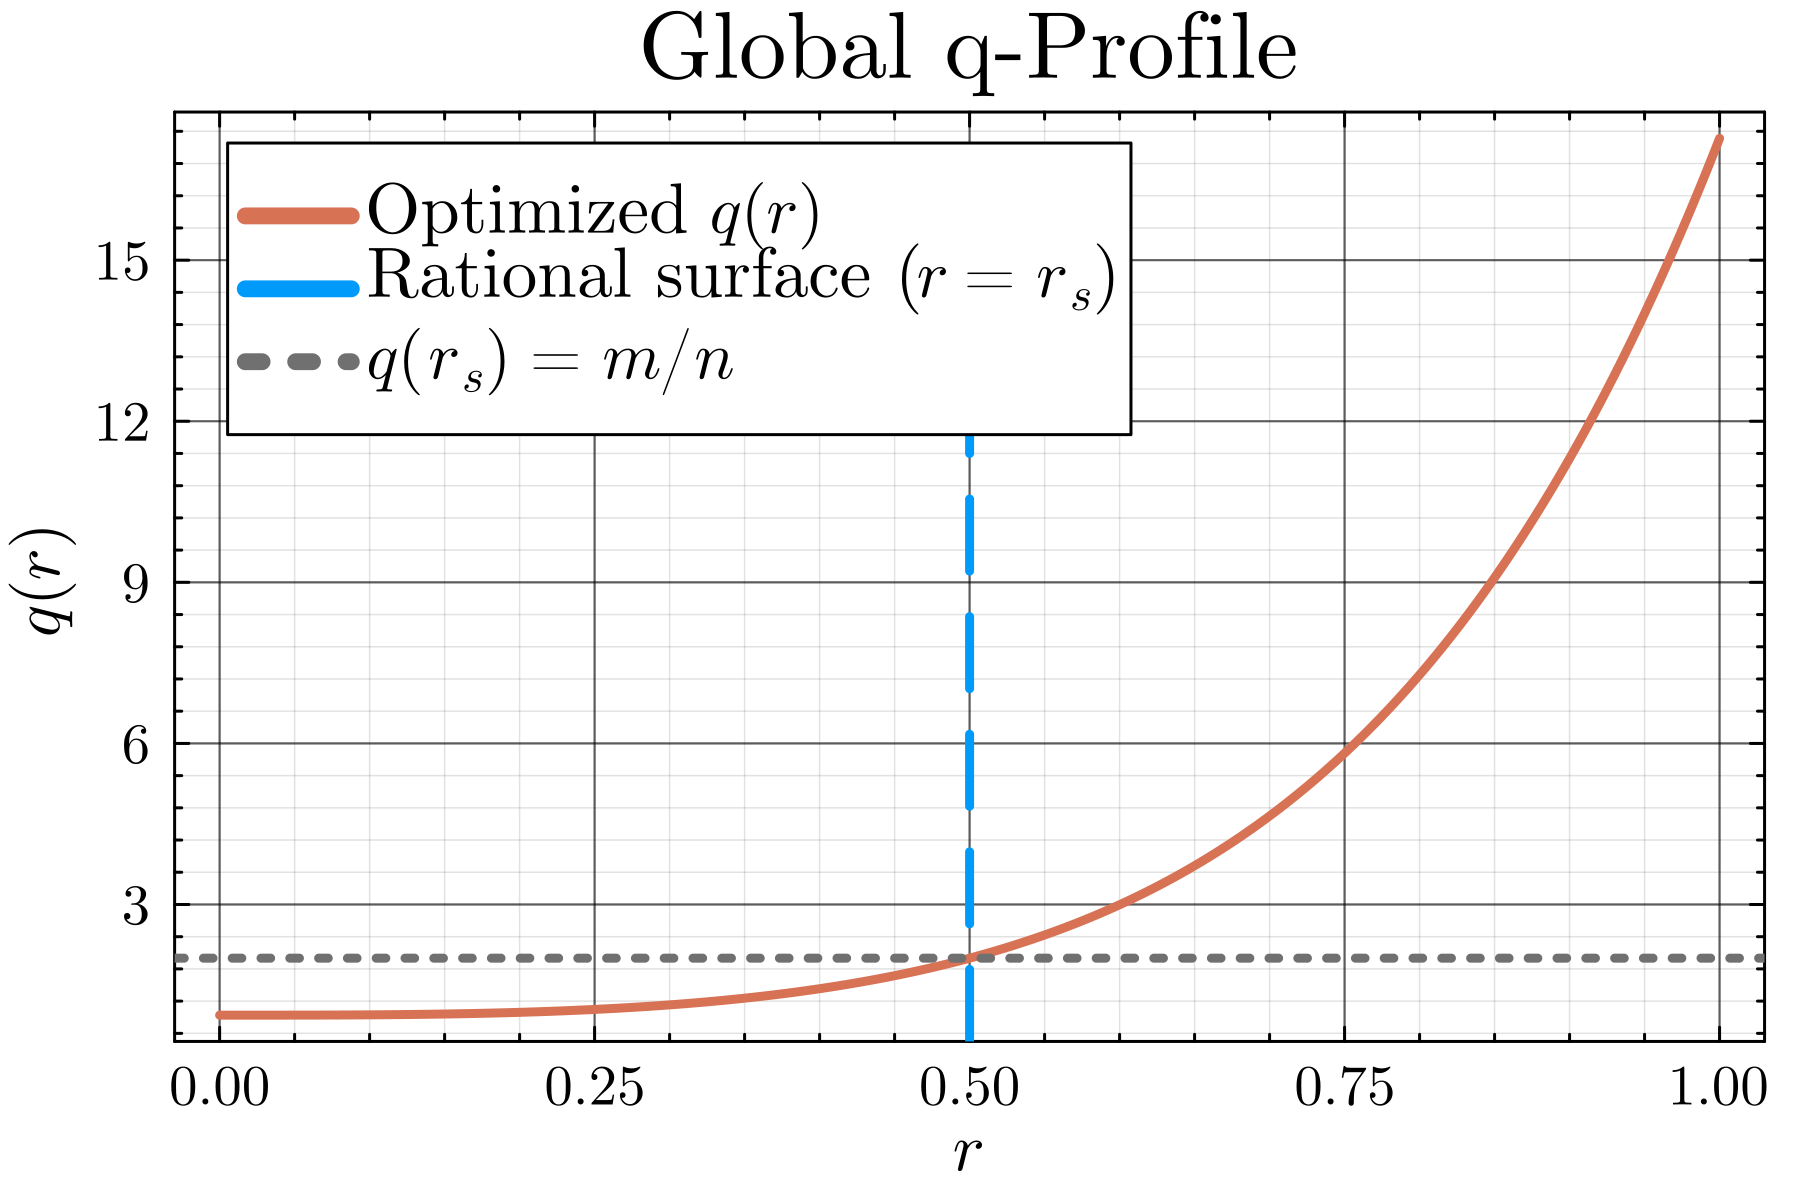

In [29]:
using Plots

# Optimized parameters
q₀, μ, γ, r₀ = 0.9386, 3.1245, 1.5677, 0.5826
a = 1.0
r_s = 0.5a

# q-profile function
q(r) = q₀ * (1 + (r/r₀)^μ)^γ

# Plot
r = range(0, a, length=300)
plot(r, q.(r), 
    lw=3, 
    label=L"Optimized $q(r)$", 
    xlabel=L"$r$", 
    ylabel=L"$q(r)$", 
    title="Global q-Profile",
    titlefontsize=20,
    tickfontsize=12,
    legendfontsize=15,
    yguidefontsize=15,
    xguidefontsize=15,
    dpi = 300,
    legend=:best
    )
vline!([r_s], ls=:dash, lw=3, label=L"Rational surface ($r = r_s$)")
hline!([2.0], ls=:dot, lw=3, label=L"$q(r_s) = m/n$")

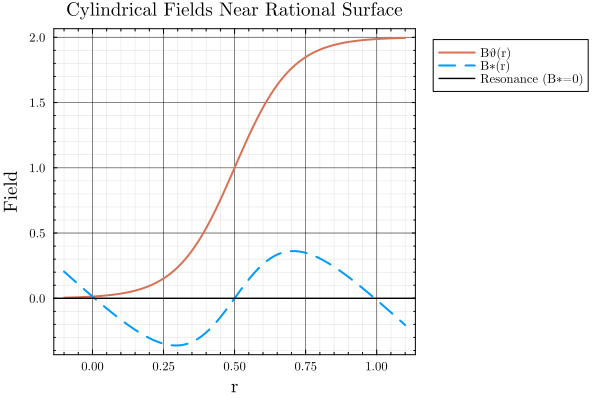

In [31]:
using Plots

# Parameters
Bθ0 = 1.0      # Amplitude of reconnecting field
Ls = 0.2       # Shear length
m_n = 2.0      # q(r_s) = m/n
Bz = 1.0       # Toroidal field
R = 1.0        # Major radius
rs = 0.5       # Rational surface

# Define Bθ(r) and B*(r)
Bθ(r) = (m_n * rs * Bz / R) + Bθ0 * tanh((r - rs)/Ls)
Bstar(r) = Bθ(r) - (m_n * r * Bz / R)

# Plot near r_s
r = range(rs - 3Ls, rs + 3Ls, length=100)
plot(r, Bθ.(r), label="Bθ(r)", lw=2, xlabel="r", ylabel="Field")
plot!(r, Bstar.(r), label="B∗(r)", lw=2, linestyle=:dash)
hline!([0.0], color=:black, label="Resonance (B∗=0)")
title!("Cylindrical Fields Near Rational Surface")